# Vertical Spatial Transcriptomics Integration

In this tutorial, we demonstrate how to leverage TopoLa to enhance the vertical integration analysis of multiple tissue sections. We use mouse mammary carcinoma sample 1 as an example. The ST data is provided by the graphST model.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
from GraphST import GraphST

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/usr/local/lib/R'

In [4]:
# the number of clusters
n_clusters = 10

## Reading data

In [5]:
# read data
file_fold = './data/' #please replace 'file_fold' with the download path
adata = sc.read_h5ad(file_fold + 'filtered_feature_bc_matrix.h5ad')
adata.var_names_make_unique()

## Plotting aligned image

Sample labels are saved in adata.obs['data']. 'S1' denotes Section1 while 'S3' denotes Section 2

Text(0.5, 1.0, 'Aligned image')

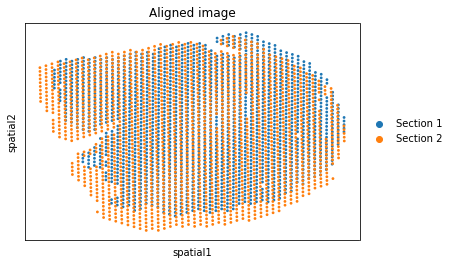

In [6]:
plt.rcParams["figure.figsize"] = (3, 3)
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
adata.obs['data'].replace({'S1':'Section 1', 'S3':'Section 2'}, inplace=True)
ax = sc.pl.embedding(adata, basis='spatial',
                color='data',
                show=False)
ax.set_title('Aligned image')
#ax.axis('off')

## Implementing GraphST for batch integration

In [7]:
# define model
model = GraphST.GraphST(adata, device=0)

# run model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 190.42it/s]

Optimization finished for ST data!


In [8]:
adata.write_h5ad(filename='./GraphST_VerticalST.h5ad')

In [9]:
adata = sc.read_h5ad(filename='./GraphST_VerticalST.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 3818 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg', 'log1p'
    obsm: 'adj', 'distance_matrix', 'emb', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'

## Joint spatial clustering

After model training, the representation for spots are generated and used as input of clustering tool for spatial clustering. Here we provid three available kinds of tools for spaital clustering, including mclust, leiden, and louvain. In our experiment, we find mclust performs better than leiden and louvain on spatial data in most cases. Therefore, we recommend using mclust.

In [11]:
# clustering
from src.utils_TopoLa import clustering

tool = 'mclust' # mclust, leiden, and louvain
lambda_val = 1e-4
# clustering
from src.utils_TopoLa import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool, lambda_val=lambda_val) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01) 

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Plotting UMAP before and after batch effect correction

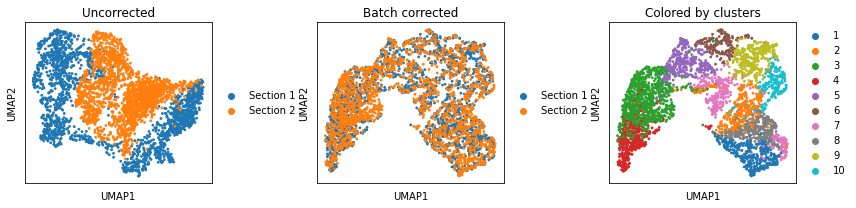

In [12]:
fig, ax_list = plt.subplots(1, 3, figsize=(12, 3))

### Plotting UMAP before batch effect correction
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
    
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='data', title='Uncorrected', 
                  ax = ax_list[0],
                  show=False)

### Plotting UMAP after batch effect correction
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, 
           color='data', 
           ax=ax_list[1], 
           title='Batch corrected', 
           #legend_loc = 'bottom margin',
           show=False)

### Color by predicted domains
sc.pl.umap(adata, color='domain', ax=ax_list[2], title='Colored by clusters', show=False)

plt.tight_layout(w_pad=0.02)

In [13]:
adata_section2 = adata[adata.obs['data']=='Section 2', :]
label = pd.read_csv('./data/metadata_sample1_section2.tsv', sep="\t")
label = label['ground_truth'].tolist()
column_name = 'domain'
df = pd.DataFrame({column_name: label}, index=adata_section2.obs_names.copy())
adata_section2.obs['domain'] = df

/tmp/ipykernel_1529/1176852021.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_section2.obs['domain'] = df


## Plotting joint clustering results

In [14]:
from sklearn import metrics

For mouse breast cancer sample1, we manually annotated section2 according to H&E image. 
The ground truth labels are avaialbe at https://drive.google.com/drive/folders/1zwGqgC84gVfDeFea5VSRU6U_QacpSnwT.  

In [15]:
import scanpy as sc
import pandas as pd

In [16]:
adata = sc.read_h5ad(filename='./GraphST_VerticalST_final.h5ad')

In [17]:
adata

AnnData object with n_obs × n_vars = 3818 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'data_colors', 'hvg', 'log1p'
    obsm: 'NR_emb', 'adj', 'distance_matrix', 'emb', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'

In [18]:
from src.utils_TopoLa import TopoLa
mat = TopoLa(adata.obsm['emb'].copy(), lambda_val=lambda_val)
adata.obsm['TopoLa_emb'] = mat

In [19]:
# adata = sc.read_h5ad(filename='./GraphST_VerticalST_final.h5ad')

In [20]:
import scib

In [21]:
scib.metrics.ilisi_graph(adata, batch_key="data", type_="embed", use_rep="emb")

0.8967541182001426

In [22]:
scib.metrics.ilisi_graph(adata, batch_key="data", type_="embed", use_rep="TopoLa_emb")

0.9029961723357349

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, random_state=2024)
embedding = pca.fit_transform(adata.obsm['emb'].copy())
adata.obsm['emb_pca'] = embedding

embedding = pca.fit_transform(adata.obsm['TopoLa_emb'].copy())
adata.obsm['TopoLa_emb_pca'] = embedding


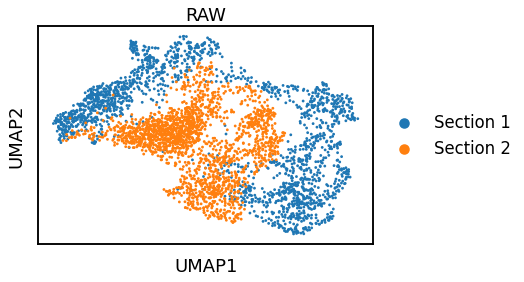

In [24]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
color='data',
# ax=ax_list[1],
title='RAW',
save = "RAW_batch.pdf")

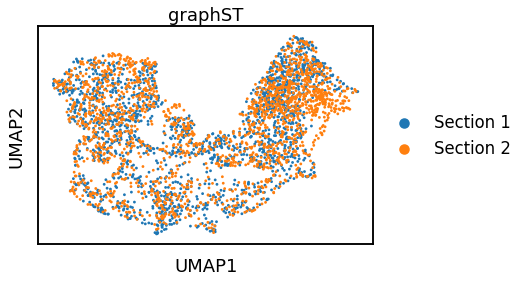

In [25]:

sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
color='data',
# ax=ax_list[1],
title='graphST',

save = "graphST_batch.pdf")

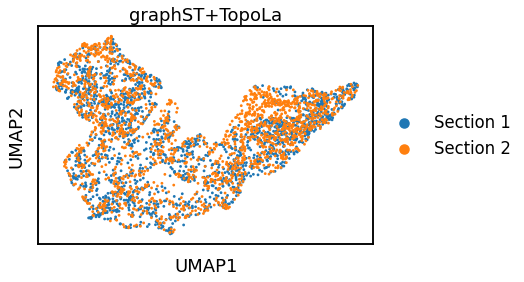

In [26]:

sc.pp.neighbors(adata, use_rep='TopoLa_emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
color='data',
# ax=ax_list[1],
title='graphST+TopoLa',

save = "graphST_TopoLa_batch.pdf")

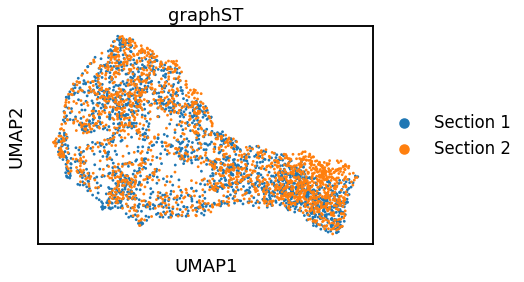

In [27]:

sc.pp.neighbors(adata, use_rep='emb', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
color='data',
# ax=ax_list[1],
title='graphST')

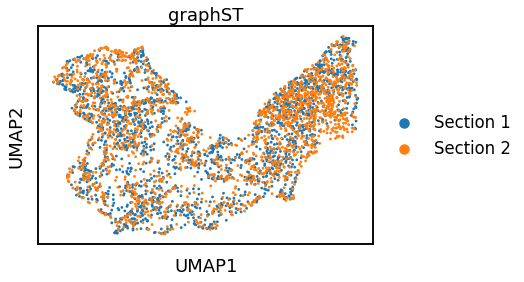

In [28]:

sc.pp.neighbors(adata, use_rep='TopoLa_emb', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata,
color='data',
# ax=ax_list[1],
title='graphST')

In [29]:
adata_section2 = adata[adata.obs['data']=='Section 2', :]
label = pd.read_csv('./data/metadata_sample1_section2.tsv', sep="\t")
label = label['ground_truth'].tolist()
column_name = 'domain'
df = pd.DataFrame({column_name: label}, index=adata_section2.obs_names.copy())
adata_section2.obs['domain'] = df

/tmp/ipykernel_1529/1176852021.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_section2.obs['domain'] = df


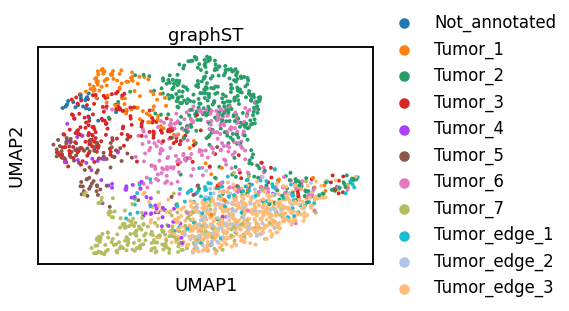

In [30]:
sc.pp.neighbors(adata_section2, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata_section2)

sc.pl.umap(adata_section2,
color='domain',
# ax=ax_list[1],
title='graphST',

save = "Raw_batch_cluster.pdf")

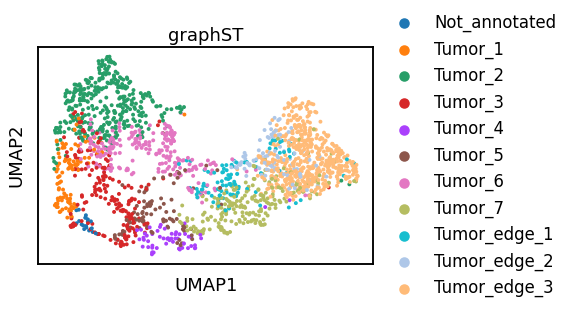

In [31]:
sc.pp.neighbors(adata_section2, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata_section2)

sc.pl.umap(adata_section2,
color='domain',
# ax=ax_list[1],
title='graphST',

save = "graphST_batch_cluster.pdf")

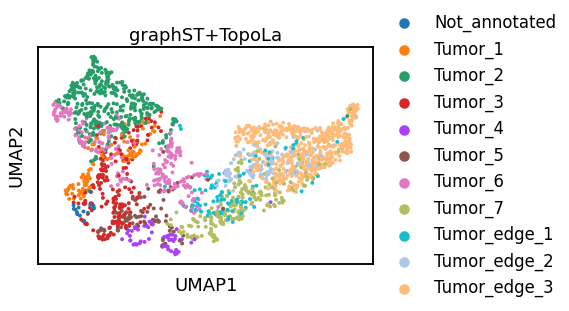

In [32]:
sc.pp.neighbors(adata_section2, use_rep='TopoLa_emb_pca', n_neighbors=10)
sc.tl.umap(adata_section2)

sc.pl.umap(adata_section2,
color='domain',
# ax=ax_list[1],
title='graphST+TopoLa',

save = "graphST_TopoLa_batch_cluster.pdf")

In [33]:
import sklearn

SCA_ASW=sklearn.metrics.silhouette_score(adata_section2.obsm['emb'].copy(),adata_section2.obs['domain'].copy())
TopoLa_ASW=sklearn.metrics.silhouette_score(adata_section2.obsm['TopoLa_emb'].copy(),adata_section2.obs['domain'].copy())

In [34]:
SCA_ASW

0.016279664

In [35]:
TopoLa_ASW

0.025957175

In [36]:
from src.utils_TopoLa import mclust_R
adata = mclust_R(adata_section2, num_cluster=n_clusters, modelNames='EEE', used_obsm='emb_pca', random_seed=2020,
                         lambda_val=lambda_val)

ARI = metrics.adjusted_rand_score(adata.obs['mclust'], adata.obs['domain'])
NMI = metrics.normalized_mutual_info_score(adata.obs['mclust'], adata.obs['domain'])
print(ARI)
print(NMI)

fitting ...
  |                                                                      |   0%

/root/miniconda3/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
0.3843727133296411
0.5531618740977623


In [37]:
adata = mclust_R(adata_section2, num_cluster=n_clusters, modelNames='EEE', used_obsm='TopoLa_emb_pca', random_seed=2020,
                         lambda_val=lambda_val)


ARI = metrics.adjusted_rand_score(adata.obs['mclust'], adata.obs['domain'])
NMI = metrics.normalized_mutual_info_score(adata.obs['mclust'], adata.obs['domain'])
print(ARI)
print(NMI)

fitting ...
  |                                                                      |   0%

/root/miniconda3/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:185: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
0.40458747949693924
0.5563509774332667
